<a href="https://colab.research.google.com/github/solevillar/scGeneFit-python/blob/master/scGeneFit_large_scale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scGeneFit import *
np.random.seed(0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#Definition of functional groups
#f_groups={functional_group_id: [mean1, mean2, ...], ...} where mean=[gene1,gene2, ...]
f_groups={0:[[0,0], [1,0], [0,1], [1,1]], 1: [[0],[1]], 2: [[0,0], [0,1], [1,0], [1,1]], 3:[[0,0], [1,0], [0,1], [1,1]], 4: [[0],[1]], 
          5: [[0,0], [0,1], [1,0], [1,1]], 6:[[0,1], [1,0], [0,1], [1,1]], 7: [[2,2],[3,3]], 8: [[0,0], [0,4], [4,0], [4,4]],
          9:[[0,0], [1,0], [0,1], [1,1]], 10: [[0],[1],[2],[4]], 11: [[0,0], [0,1], [1,0], [1,1]],
          12:[[0,0], [1,0], [0,1], [1,1]], 13: [[0],[1]], 14: [[0,0], [0,1], [1,0], [1,1]]}

#cell_types_aux=[[s for s in range(len(f_groups[i]))] for i in f_groups.keys()]
#all_cell_types=list(itertools.product(*cell_types_aux))

In [0]:
def create_data(f_groups, cell_types, sigma, n, repeat):
  aux=list(f_groups.keys())
  data=np.zeros( (0, sum([len(f_groups[aux[i]][0])*repeat[i] for i in range(len(aux))]) ))
  for cell in cell_types:
    expression=np.zeros((n, 0))
    for t in range(len(cell)):
      mean=f_groups[t][cell[t]]
      mean=np.concatenate([[mean[i]]*repeat[t] for i in range(len(mean))])
      expression=np.concatenate([expression, np.random.multivariate_normal(mean, sigma*np.identity(len(mean)), size=n)], axis=1)
    data=np.concatenate([data, expression])
  labels=np.concatenate([[i]*n for i in range(len(cell_types))])
  return data,labels

In [0]:
#create data
classes=40
n=25
n_groups=len(list(f_groups.keys()))
cell_types = np.zeros((classes, n_groups))
for i in range(n_groups):
    aux=np.random.permutation(classes)
    idx=list(f_groups.keys())[i]
    n_means=len(f_groups[idx])
    start=0
    offset=int(classes/n_means)
    for s in range(n_means):
        cell_types[aux[start:start+offset], i] = s
        start=start+offset+1
cell_types=cell_types.astype(int)

Text(0, 0.5, 'synthetic cells')

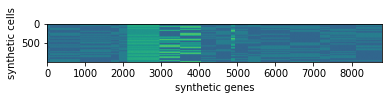

In [5]:

repeat=[10,10,10,10,10]+[np.random.randint(100, 800) for i in range(len(f_groups.keys())-5)]
#display data example with 9 classes and 5 relevant markers
#cell_types= [[np.random.randint(0, len(f_groups[i])) for i in f_groups.keys()] for j in range(classes)]

sc_gene, sc_labels=create_data(f_groups, cell_types, 0.5, n, repeat)
plt.imshow(sc_gene)
plt.xlabel('synthetic genes')
plt.ylabel('synthetic cells')

In [6]:
#create data
print(sc_gene.shape)
X_train, y_train= sc_gene, sc_labels
X_test, y_test= X_train, y_train


(1000, 8798)


In [0]:
#Choose an evaluation method (e.g. classification accuracy)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestCentroid
clf=NearestCentroid()
#clf=RandomForestClassifier()

def performance(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [8]:
markers_ova=one_vs_all_selection(X_train,y_train)
one_vs_all_accuracy=performance(X_train[:,markers_ova], y_train, X_test[:,markers_ova], y_test, clf)
print(one_vs_all_accuracy)

0.775


In [9]:
s_rate=0.2
m_range=range(25,55,5)

#obtain markers
#one vs all:
opt_epsilon=[0.1 for i in m_range]
#markers_ova=one_vs_all_selection(X_train,y_train)

#scGeneFit
markers_lp=[]
for m, epsilon in zip(m_range, opt_epsilon):
  aux=scGeneFit2.get_markers(X_train, y_train, m, sampling_rate=s_rate, epsilon=epsilon, fast=True)
  markers_lp= markers_lp + [aux]

(41, 8798)
Solving a linear program with 8798 variables and 41 constraints
Time elapsed: 475.58316946029663 seconds
(42, 8798)
Solving a linear program with 8798 variables and 42 constraints
Time elapsed: 473.6112551689148 seconds
(42, 8798)
Solving a linear program with 8798 variables and 42 constraints
Time elapsed: 512.3771317005157 seconds
(43, 8798)
Solving a linear program with 8798 variables and 43 constraints
Time elapsed: 556.9540059566498 seconds
(47, 8798)
Solving a linear program with 8798 variables and 47 constraints
Time elapsed: 557.951940536499 seconds
(40, 8798)
Solving a linear program with 8798 variables and 40 constraints
Time elapsed: 611.2934892177582 seconds


In [0]:
from google.colab import files

0.775
[0.602, 0.559, 0.825, 0.924, 0.969, 0.943]


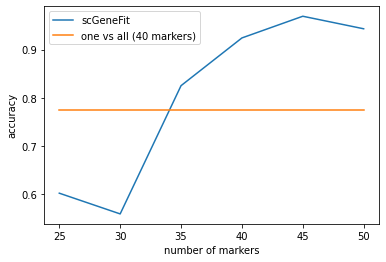

In [11]:
#one vs all
markers_ova=one_vs_all_selection(X_train,y_train)
one_vs_all_accuracy=performance(X_train[:,markers_ova], y_train, X_test[:,markers_ova], y_test, clf)
print(one_vs_all_accuracy)
#scGeneFit
l=[]
for markers in markers_lp:
  l=l+[performance(X_train[:,markers], y_train, X_test[:,markers], y_test, clf)]
print(l)

#plot
plt.plot(m_range, l)+plt.plot(m_range,[one_vs_all_accuracy for i in l])
plt.legend(["scGeneFit", "one vs all (40 markers)"])
plt.xlabel("number of markers")
plt.ylabel("accuracy")
plt.savefig("plot.pdf")



In [0]:
files.download("plot.pdf")

In [0]:
from google.colab import files
plt.show()
plt.savefig("accuracy_8.pdf")
files.download("accuracy_8.pdf")

In [0]:
log(Poisson(exp(X_train)))+1

In [0]:
plt2=plt

In [0]:
plt

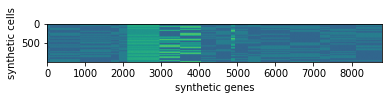

In [15]:
plt.imshow(sc_gene)
plt.xlabel('synthetic genes')
plt.ylabel('synthetic cells')
plt.savefig('data.pdf')
files.download('data.pdf')

Computing TSNE embedding
Elapsed time: 28.76391053199768 seconds


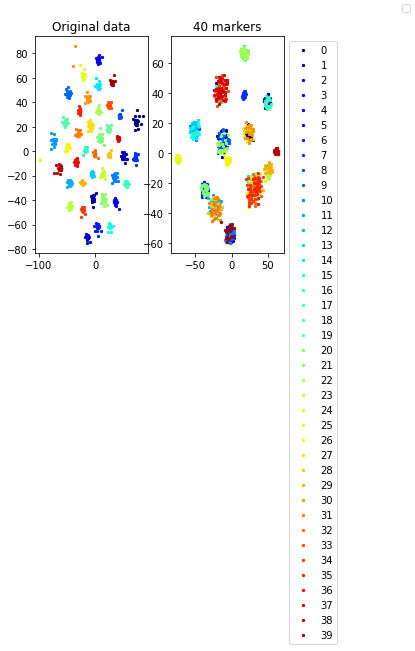

In [41]:
tsne_ova=scGeneFit2.plot_marker_selection(X_train,markers_ova,y_train, 10, 10)
tsne_ova.legend('')
tsne_ova.savefig("tsne_ova.pdf")
files.download("tsne_ova.pdf")

Computing TSNE embedding
Elapsed time: 29.15335488319397 seconds


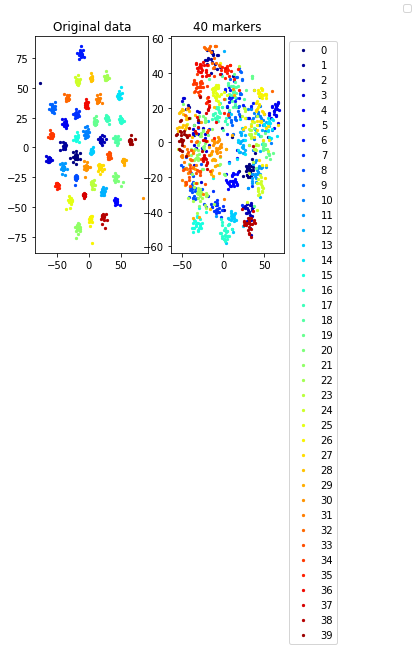

In [34]:
tsne_lp=plot_marker_selection(X_train,markers_lp[3],y_train, 10)
tsne_lp.legend('')
tsne_lp.savefig("tsne_lp.pdf")
files.download("tsne_lp.pdf")

In [38]:
import scGeneFit2
import imp
imp.reload(scGeneFit2)

<module 'scGeneFit2' from '/content/scGeneFit2.py'>

Computing TSNE embedding
Elapsed time: 30.68835210800171 seconds


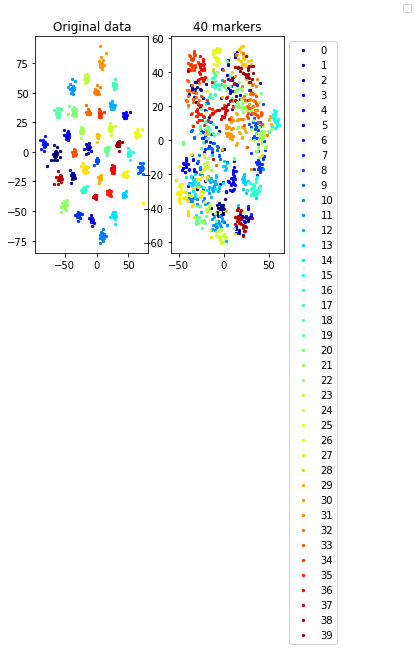

In [42]:
tsne_lp=scGeneFit2.plot_marker_selection(X_train,markers_lp[3],y_train, 10,10)
tsne_lp.legend('')
tsne_lp.savefig("tsne_lp.pdf")
files.download("tsne_lp.pdf")